# convolutional autoencoder with MNIST
##  inspired by the [Swarbrick's blog](https://swarbrickjones.wordpress.com/2015/04/29/convolutional-autoencoders-in-pythontheanolasagne/) and Professor [G.E.Hinton's paper](http://science.sciencemag.org/content/313/5786/504)

In [1]:
import sklearn
from sklearn import datasets
from PIL import Image
from IPython.display import Image as IPImage
import numpy as np
import gzip
import pickle
from sklearn.linear_model import LogisticRegression as LR
from sklearn.decomposition import PCA
import sklearn
import pandas

In [2]:
f = gzip.open('/home/rui/Downloads/mnist.pkl.gz', 'rb')
try:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
except:
    train_set, valid_set, test_set = pickle.load(f)
f.close()
X, Y = train_set
X = np.reshape(X, (-1, 1, 28, 28))
X_out = X.reshape((X.shape[0], -1))

In [3]:
Y.shape

(50000,)

In [4]:
arr = np.arange(50000)
np.random.shuffle(arr)
train_index = arr[0:30000]
test_index = arr[30000:50000]

In [5]:
X_train,X_test = [X_out[train_index],X_out[test_index]]
Y_train,Y_test = [Y[train_index],Y[test_index]]

In [6]:
def train_and_eval( model, train_x, train_y, test_x, test_y ):
    model.fit( train_x, train_y )
    p = model.predict( test_x )
    OA = sum(test_y==p)/len(test_y)
    return OA

### Classification with original data

In [7]:
lr = LR(C=1)
auc = train_and_eval( lr, X_train, Y_train, \
    X_test, Y_test )
auc

0.9123

In [8]:
svm=sklearn.svm.SVC(kernel='linear',C=1,shrinking=False)
auc = train_and_eval( svm, X_train, Y_train, \
    X_test, Y_test )
auc

0.92449999999999999

### Classification with the first 256 principle components.

In [7]:
pca = PCA(n_components=256)
pcomp = pca.fit_transform(X_out)
X_pcomp_train,X_pcomp_test = [pcomp[train_index],pcomp[test_index]]

In [8]:
lr = LR(C=1)
auc = train_and_eval( lr, X_pcomp_train, Y_train, \
    X_pcomp_test, Y_test )
auc

0.90849999999999997

In [9]:
svm=sklearn.svm.SVC(kernel='linear',C=1,shrinking=False)
auc = train_and_eval( svm, X_pcomp_train, Y_train, \
    X_pcomp_test, Y_test )
auc

0.92795000000000005

In [12]:
pca_reconstruct = pca.inverse_transform(pcomp)

In [13]:
temp=np.load('CAE_MNIST_learned_feature.npz')
X_pred = temp['arr_0']
X_encode = temp['arr_1']

In [14]:
def get_picture_array(X, rescale=2):
    array = X.reshape(28,28)
    array = np.clip(array, a_min = 0, a_max = 255)
    return  array.repeat(rescale, axis = 0).repeat(rescale, axis = 1).astype(np.uint8())

def compare_images_array(index):
    length = len(index)
    original_image = Image.fromarray(get_picture_array(255 * X[index[0]]))
    width,height = original_image.size
    new_size = (width * length, height*3)
    new_im = Image.new('L', new_size)
    for i in range(length):
        original_image = Image.fromarray(get_picture_array(255 * X[index[i]]))
        CAE_image = Image.fromarray(get_picture_array(255 * X_pred[index[i]]))
        pca_image = Image.fromarray(get_picture_array(255 * pca_reconstruct[index[i]]))
        new_im.paste(original_image, (i*width,0))
        new_im.paste(CAE_image, (i*width,height))
        new_im.paste(pca_image, (i*width,height*2))
    new_im.save('test.png', format="PNG")
    return IPImage('test.png')

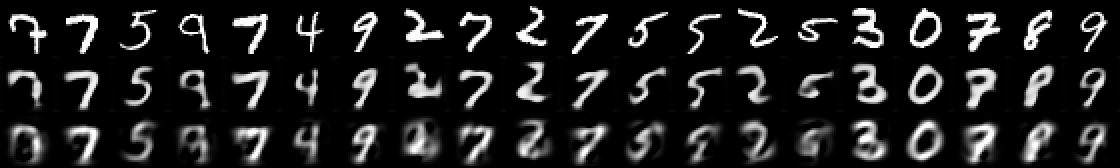

In [15]:
index = np.random.random_integers(0, high=49999, size=20)
compare_images_array(index)

### Classification with the 16 dimension learned feature.

In [17]:
lr = LR(C=1)
auc = train_and_eval( lr, X_encode[train_index], Y[train_index], \
    X_encode[test_index], Y[test_index] )
auc

0.86019999999999996

In [18]:
svm=sklearn.svm.SVC(kernel='linear',C=1,shrinking=False)
auc = train_and_eval( svm, X_encode[train_index], Y[train_index], \
    X_encode[test_index], Y[test_index] )
auc

0.90634999999999999